In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
import pathlib

Using TensorFlow backend.


In [3]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [4]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [5]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [6]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [7]:
def find_center(y):
    center_x = (y[0, 2] + y[0, 0]) / 2
    center_y = (y[0, 3] + y[0, 1]) / 2 
    return np.array([center_x, center_y, center_x, center_y])


def scale(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    err_x, err_y = np.random.random(2)  
    
    err_x = 1 + (2 * err_x - 1) * err
    err_y = 1 + (2 * err_y - 1) * err
    
    err = np.array([err_x, err_y, err_x, err_y])
    
    return (x * np.reshape(err, (1, 1, 4)) + np.reshape(center, (1, 1, 4)), 
            y * np.reshape(err, (1, 4)) + np.reshape(center, (1, 4)))
    

def move(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    size_x = (y[0, 2] - y[0, 0]) / 2
    size_y = (y[0, 3] - y[0, 1]) / 2
    
    err_cx, err_cy = np.random.random(2)  
    
    err_cx = (2 * size_x * err_cx - size_x) * err
    err_cy = (2 * size_y * err_cy - size_y) * err
    
    err = np.array([err_cx, err_cy, err_cx, err_cy])
    
    return x + np.reshape(err + center, (1, 1, 4)), y + np.reshape(err + center, (1, 4))
    
def aug_batch(x, y, err=0.1):
    x, y = scale(x, y, err)
    x, y = move(x, y, err)
    return x, y

In [8]:
def yield_batch(data, batch):
    votes, answers = data
    counts = votes[["userId"]].groupby("itemId").count()
    feat = votes.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, batch)
        x = feat.loc[item_id]
        y = answers.loc[item_id]
        yield x, y

In [9]:
def yield_batch_val(data):
    votes, answers = data
    counts = votes[["userId"]].groupby("itemId").count()
    feat = votes.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = list(set(votes.index))
    while True:
        x = feat.loc[item_ids]
        y = answers.loc[item_ids]
        yield x, y

In [10]:
def yield_batch_test(data):
    counts = data[["userId"]].groupby("itemId").count()
    feat = data.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = data.index.unique()
    for item_id in item_ids:
        x = feat.loc[[item_id]]
        yield x

In [11]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [12]:
def make_model(units):
    K.clear_session()
    
    y = x = layers.Input(shape=(21,))
    
    y = layers.Dense(
        units=units * 8,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [13]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [14]:
class DecayingCyclicLR(callbacks.Callback):

    def __init__(self, max_lr, half=4, decay=0.5):
        super().__init__()

        self.max_lr = max_lr
        self.half = half
        self.decay = decay
        
        self.steps = None
        self.epochs = None
        
        self.iterations = 0
        self.history = {}
        
    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
     
        self.steps = self.params["steps"]
        self.epochs = self.params["epochs"]
        
        lr = 1 / self.steps / self.half
        
        K.set_value(self.model.optimizer.lr, lr)
        
    def clr(self):
        num, cycle = divmod(self.iterations / (self.steps * self.half), 2)
        
        if cycle <= 1:
            return self.max_lr * cycle * self.decay ** num
        
        return (self.max_lr - self.max_lr * (cycle - 1)) * self.decay ** num
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nLearning rate: {K.get_value(self.model.optimizer.lr):.1e}")
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [18]:
def train_model(data_train, data_val, units, batch, test=False):
    
    max_lr = 3.9e-03
    
    steps_per_epoch = 1000 // batch
    epochs = 40
    
    model = make_model(units)  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train, batch),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=1,
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingCyclicLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model1.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train, batch),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=1,
        )
    
    model = models.load_model("../processed/model1.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

In [16]:
FOLDS = 10

def train_oof(train_set, test_set, units=16, batch=1):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        data_train = (x_train.loc[ids_train], y_train.loc[ids_train])
        data_val = (x_train.loc[ids_valid], y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units, batch)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {np.std(scores):0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)


Fold - 1 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2816      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 13,748
Trainable params: 13,748
Non-trainable params: 0
_________________________________________________________

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5742 - val_loss: -0.5607

Epoch 00037: val_loss improved from -0.55934 to -0.56068, saving model to ../processed/model1.h5

Learning rate: 1.8e-04
Epoch 38/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5880 - val_loss: -0.5543

Epoch 00038: val_loss did not improve from -0.56068

Learning rate: 1.2e-04
Epoch 39/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5912 - val_loss: -0.5578

Epoch 00039: val_loss did not improve from -0.56068

Learning rate: 6.1e-05
Epoch 40/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5997 - val_loss: -0.5581

Epoch 00040: val_loss did not improve from -0.56068

Learning rate: 3.0e-08

Fold - 2 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
__________________________


Epoch 00032: val_loss improved from -0.53948 to -0.54098, saving model to ../processed/model1.h5

Learning rate: 6.1e-08
Epoch 33/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5944 - val_loss: -0.5413

Epoch 00033: val_loss improved from -0.54098 to -0.54130, saving model to ../processed/model1.h5

Learning rate: 6.1e-05
Epoch 34/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.6018 - val_loss: -0.5421

Epoch 00034: val_loss improved from -0.54130 to -0.54208, saving model to ../processed/model1.h5

Learning rate: 1.2e-04
Epoch 35/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5837 - val_loss: -0.5417

Epoch 00035: val_loss did not improve from -0.54208

Learning rate: 1.8e-04
Epoch 36/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5878 - val_loss: -0.5328

Epoch 00036: val_loss did not improve from -0.54208

Learning rate: 2.4e-04
Epoch 37/40
1000/1000 [==============================] - 3s 

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5716 - val_loss: -0.5588

Epoch 00027: val_loss did not improve from -0.56185

Learning rate: 3.7e-04
Epoch 28/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5647 - val_loss: -0.5458

Epoch 00028: val_loss did not improve from -0.56185

Learning rate: 4.9e-04
Epoch 29/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5630 - val_loss: -0.5389

Epoch 00029: val_loss did not improve from -0.56185

Learning rate: 3.7e-04
Epoch 30/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5749 - val_loss: -0.5559

Epoch 00030: val_loss did not improve from -0.56185

Learning rate: 2.4e-04
Epoch 31/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5843 - val_loss: -0.5625

Epoch 00031: val_loss improved from -0.56185 to -0.56248, saving model to ../processed/model1.h5

Learning rate: 1.2e-04
Epoch 32/40
1000/1000 [==============================] - 


Epoch 00022: val_loss did not improve from -0.54426

Learning rate: 4.9e-04
Epoch 23/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5483 - val_loss: -0.5360

Epoch 00023: val_loss did not improve from -0.54426

Learning rate: 2.4e-04
Epoch 24/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5803 - val_loss: -0.5526

Epoch 00024: val_loss improved from -0.54426 to -0.55258, saving model to ../processed/model1.h5

Learning rate: 1.2e-07
Epoch 25/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5834 - val_loss: -0.5557

Epoch 00025: val_loss improved from -0.55258 to -0.55568, saving model to ../processed/model1.h5

Learning rate: 1.2e-04
Epoch 26/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5761 - val_loss: -0.5399

Epoch 00026: val_loss did not improve from -0.55568

Learning rate: 2.4e-04
Epoch 27/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5678 - val_loss: -0.5348


1000/1000 [==============================] - 3s 3ms/step - loss: -0.5692 - val_loss: -0.5229

Epoch 00018: val_loss did not improve from -0.53520

Learning rate: 4.9e-04
Epoch 19/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5567 - val_loss: -0.5030

Epoch 00019: val_loss did not improve from -0.53520

Learning rate: 7.3e-04
Epoch 20/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5409 - val_loss: -0.5091

Epoch 00020: val_loss did not improve from -0.53520

Learning rate: 9.7e-04
Epoch 21/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5531 - val_loss: -0.5216

Epoch 00021: val_loss did not improve from -0.53520

Learning rate: 7.3e-04
Epoch 22/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5540 - val_loss: -0.5023

Epoch 00022: val_loss did not improve from -0.53520

Learning rate: 4.9e-04
Epoch 23/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5758 - val_loss: -0.51

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5193 - val_loss: -0.5174

Epoch 00014: val_loss did not improve from -0.53922

Learning rate: 9.7e-04
Epoch 15/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5474 - val_loss: -0.5303

Epoch 00015: val_loss did not improve from -0.53922

Learning rate: 4.9e-04
Epoch 16/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5599 - val_loss: -0.5424

Epoch 00016: val_loss improved from -0.53922 to -0.54235, saving model to ../processed/model1.h5

Learning rate: 2.4e-07
Epoch 17/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5672 - val_loss: -0.5486

Epoch 00017: val_loss improved from -0.54235 to -0.54860, saving model to ../processed/model1.h5

Learning rate: 2.4e-04
Epoch 18/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5591 - val_loss: -0.5107

Epoch 00018: val_loss did not improve from -0.54860

Learning rate: 4.9e-04
Epoch 19/40



Epoch 00009: val_loss did not improve from -0.55579

Learning rate: 4.9e-04
Epoch 10/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5280 - val_loss: -0.5227

Epoch 00010: val_loss did not improve from -0.55579

Learning rate: 9.8e-04
Epoch 11/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5115 - val_loss: -0.5093

Epoch 00011: val_loss did not improve from -0.55579

Learning rate: 1.5e-03
Epoch 12/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5016 - val_loss: -0.4903

Epoch 00012: val_loss did not improve from -0.55579

Learning rate: 1.9e-03
Epoch 13/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4955 - val_loss: -0.5019

Epoch 00013: val_loss did not improve from -0.55579

Learning rate: 1.5e-03
Epoch 14/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4995 - val_loss: -0.5303

Epoch 00014: val_loss did not improve from -0.55579

Learning rate: 9.7e-04
Epoch 15/40
1

1000/1000 [==============================] - 3s 3ms/step - loss: -0.4315 - val_loss: -0.4094

Epoch 00005: val_loss did not improve from -0.44230

Learning rate: 2.9e-03
Epoch 6/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4644 - val_loss: -0.4881

Epoch 00006: val_loss improved from -0.44230 to -0.48813, saving model to ../processed/model1.h5

Learning rate: 1.9e-03
Epoch 7/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4985 - val_loss: -0.5471

Epoch 00007: val_loss improved from -0.48813 to -0.54710, saving model to ../processed/model1.h5

Learning rate: 9.7e-04
Epoch 8/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5219 - val_loss: -0.5654

Epoch 00008: val_loss improved from -0.54710 to -0.56536, saving model to ../processed/model1.h5

Learning rate: 4.9e-07
Epoch 9/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5489 - val_loss: -0.5368

Epoch 00009: val_loss did not improve from -0.5


Learning rate: 9.8e-04
Epoch 2/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4301 - val_loss: -0.4411

Epoch 00002: val_loss improved from -0.41699 to -0.44113, saving model to ../processed/model1.h5

Learning rate: 2.0e-03
Epoch 3/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4214 - val_loss: -0.4339

Epoch 00003: val_loss did not improve from -0.44113

Learning rate: 2.9e-03
Epoch 4/40
1000/1000 [==============================] - ETA: 0s - loss: -0.41 - 3s 3ms/step - loss: -0.4157 - val_loss: -0.4496

Epoch 00004: val_loss improved from -0.44113 to -0.44957, saving model to ../processed/model1.h5

Learning rate: 3.9e-03
Epoch 5/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4377 - val_loss: -0.4678

Epoch 00005: val_loss improved from -0.44957 to -0.46779, saving model to ../processed/model1.h5

Learning rate: 2.9e-03
Epoch 6/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4696 - val_los

Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5391 - intersection_over_union: -0.1063 - val_loss: 0.4258 - val_intersection_over_union: -0.2161
Epoch 1/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.3502 - val_loss: -0.4193

Epoch 00001: val_loss improved from inf to -0.41934, saving model to ../processed/model1.h5

Learning rate: 9.8e-04
Epoch 2/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4209 - val_loss: -0.4549

Epoch 00002: val_loss improved from -0.41934 to -0.45494, saving model to ../processed/model1.h5

Learning rate: 2.0e-03
Epoch 3/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4253 - val_loss: -0.4528

Epoch 00003: val_loss did not improve from -0.45494

Learning rate: 2.9e-03
Epoch 4/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4222 - val_loss: -0.4062

Epoch 00004: val_loss did not improve from -0.45494

Learning rate: 3.9e-03
Epoch 5/40
1000/

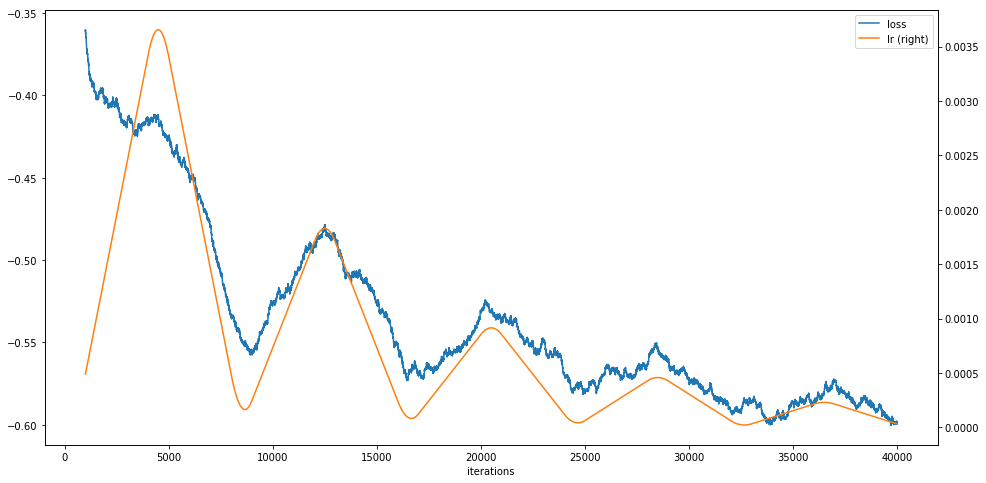

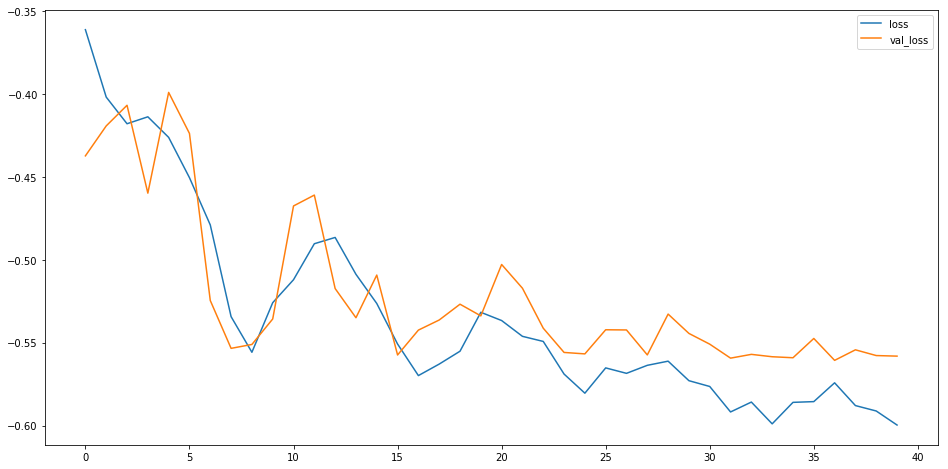

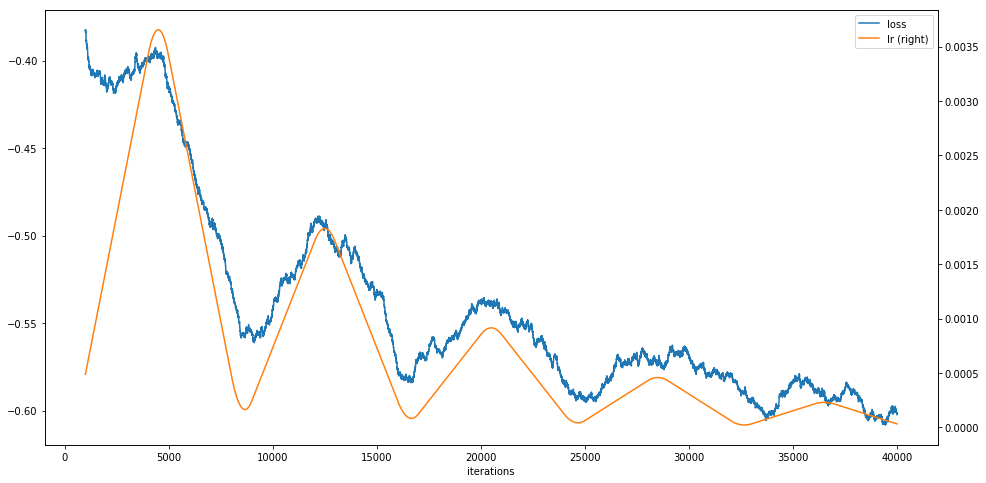

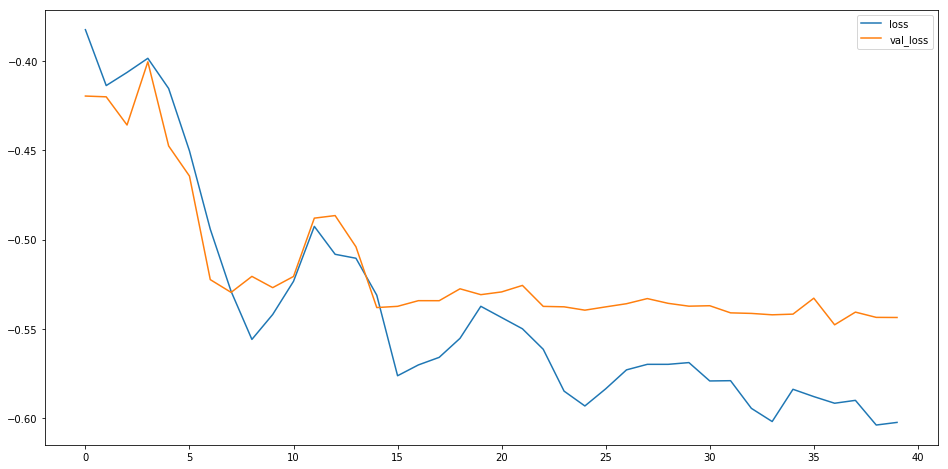

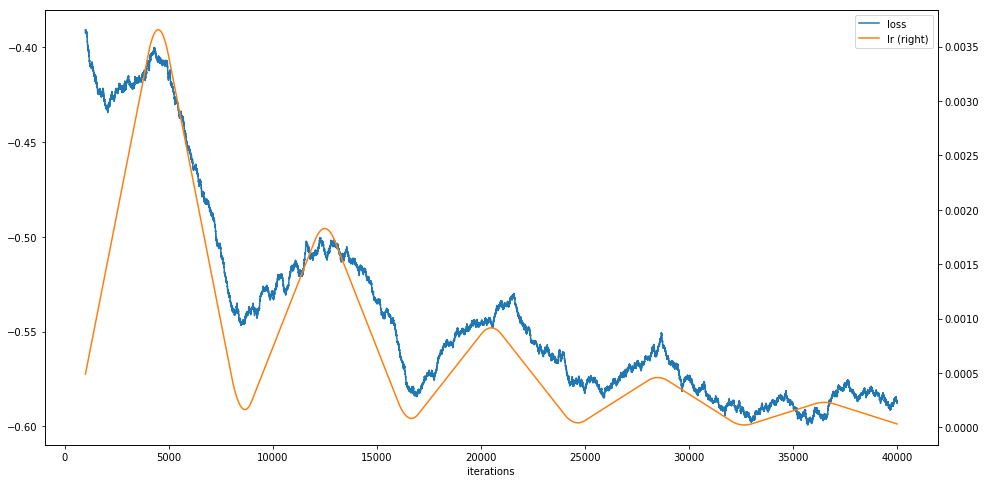

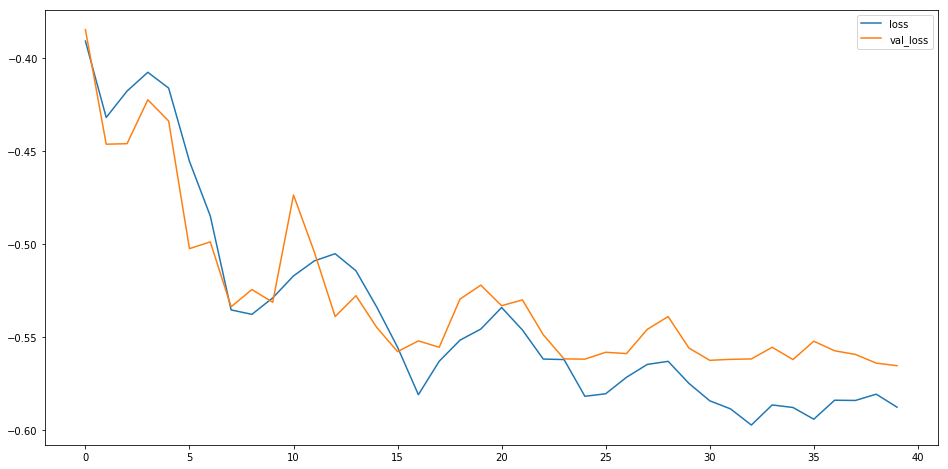

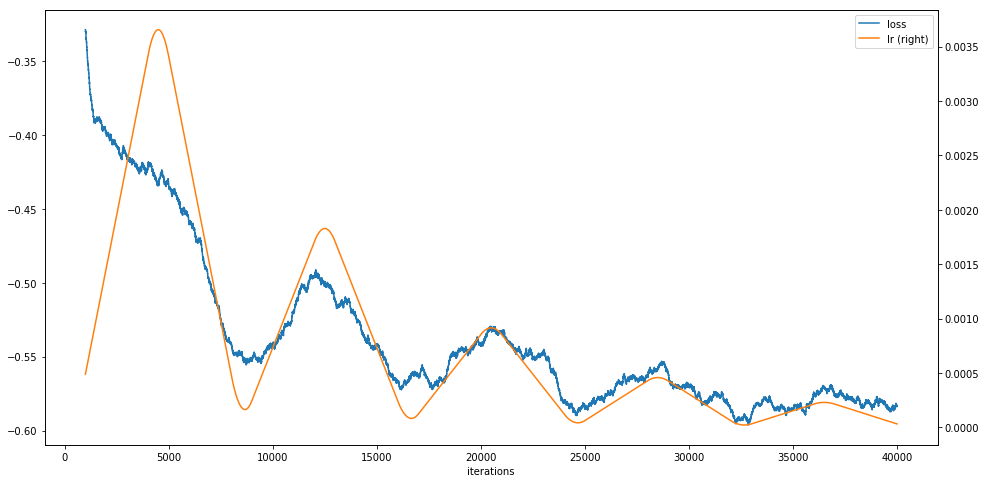

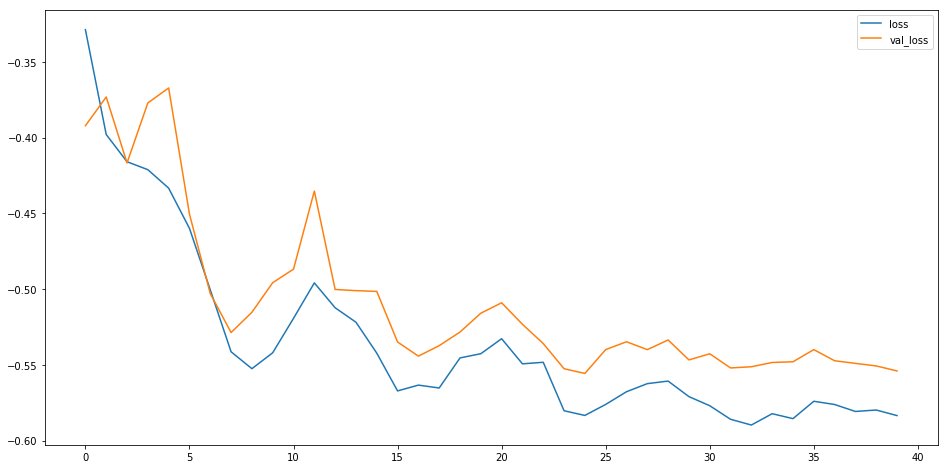

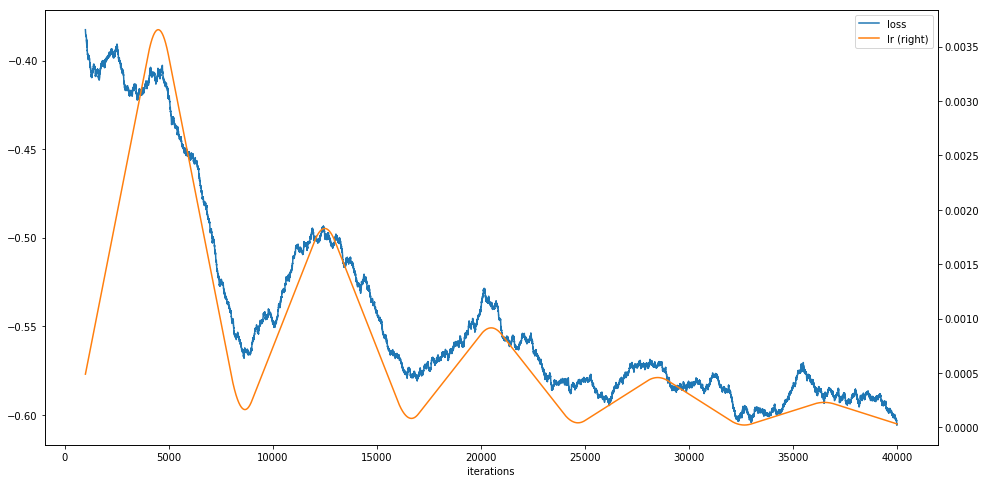

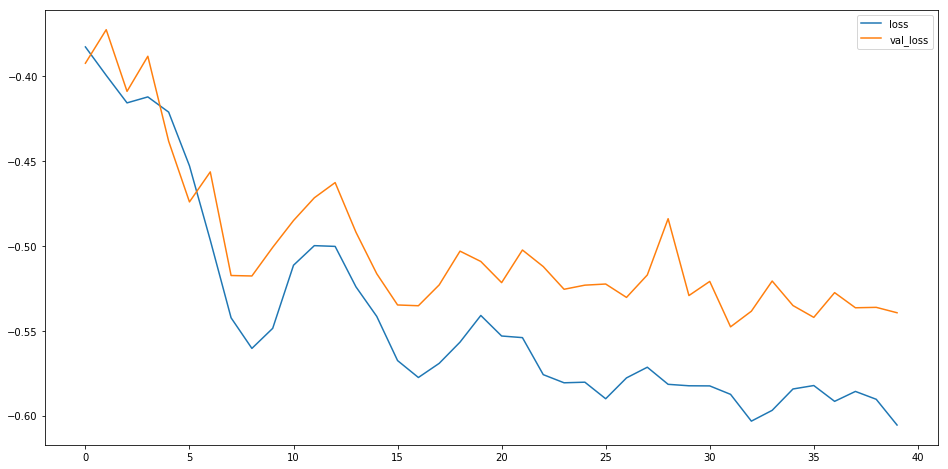

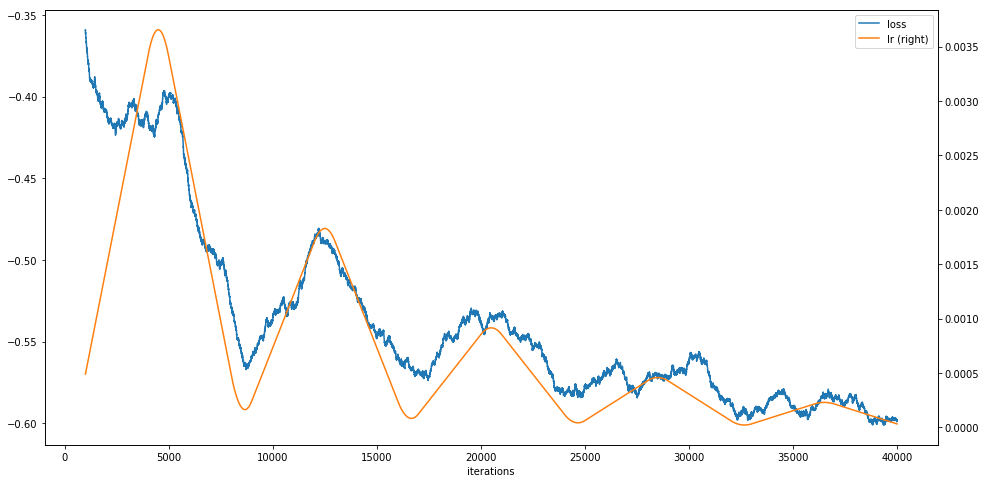

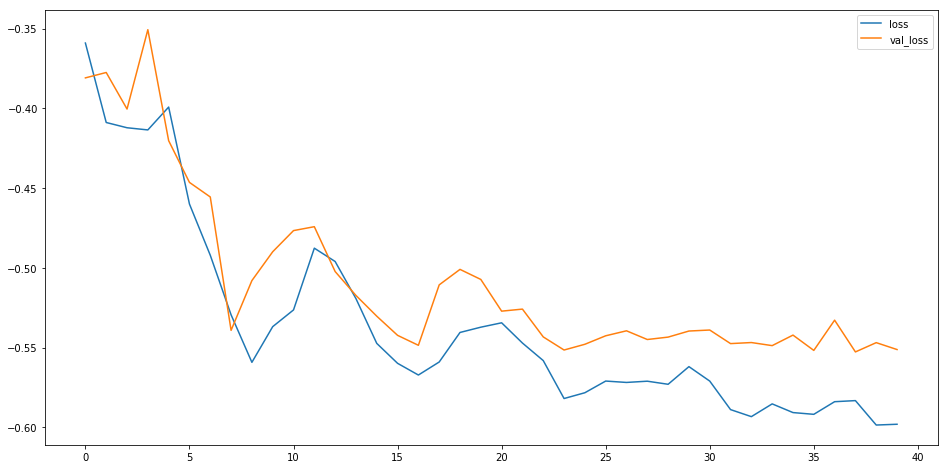

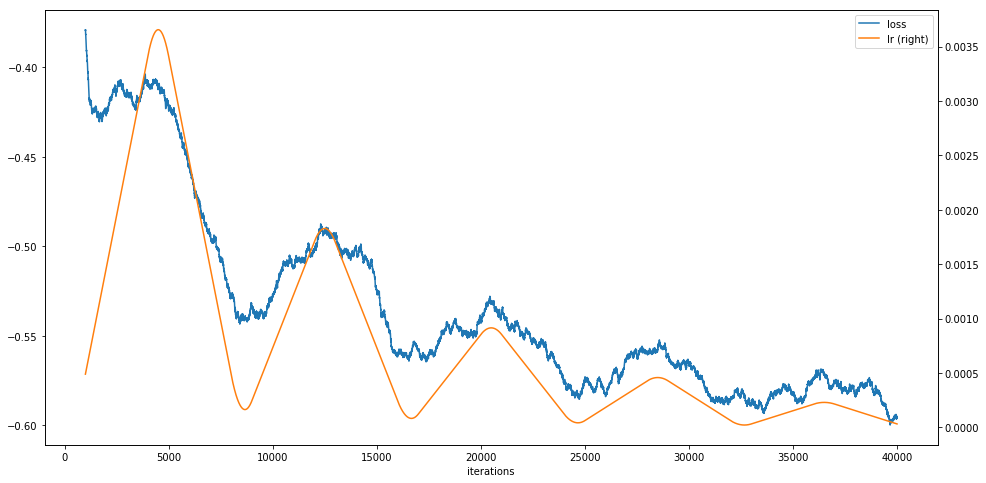

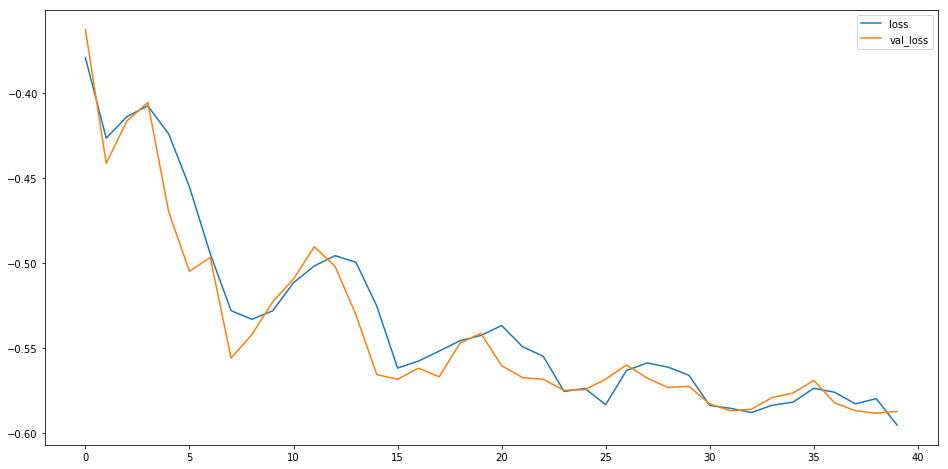

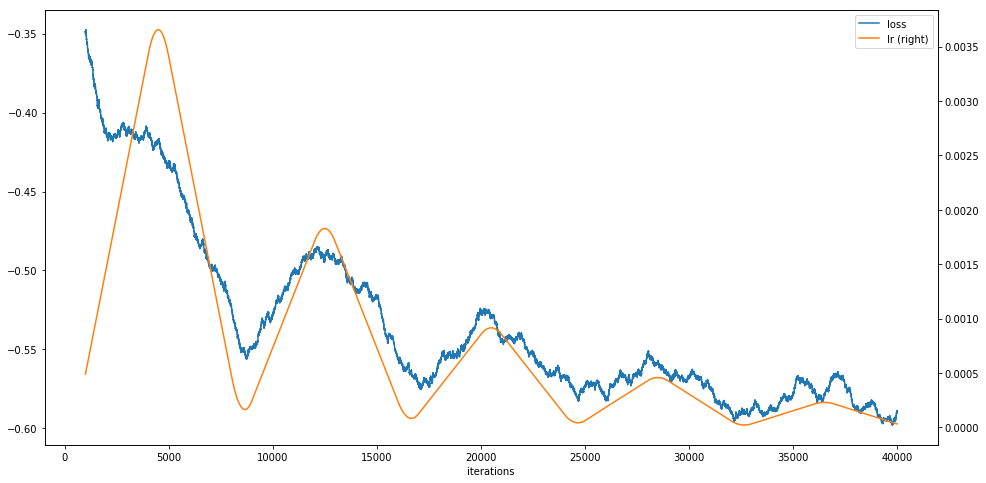

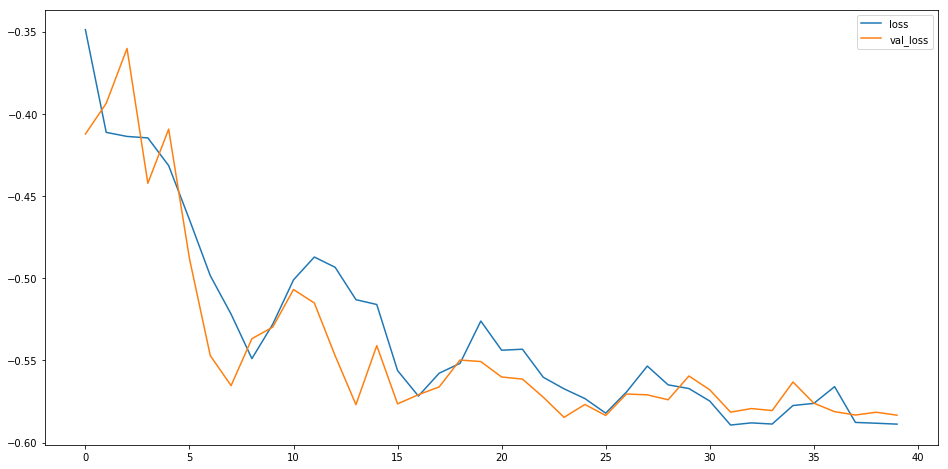

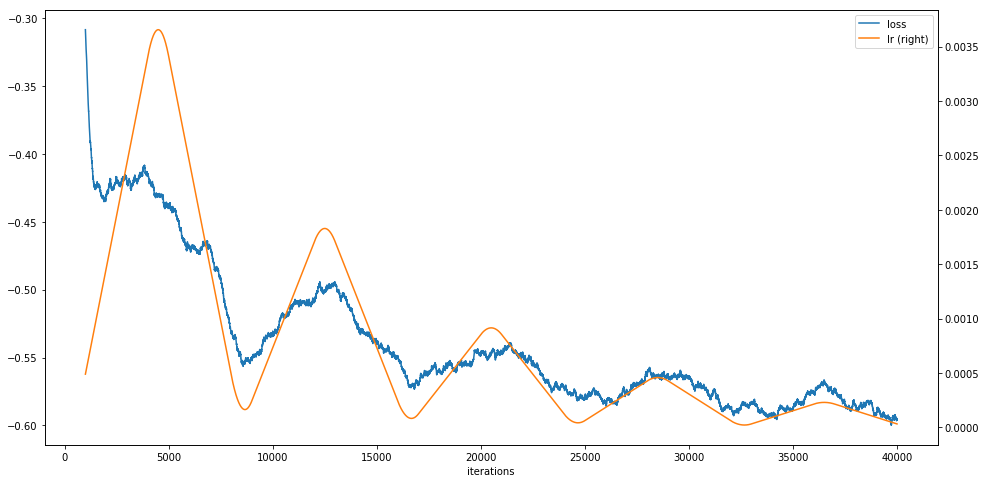

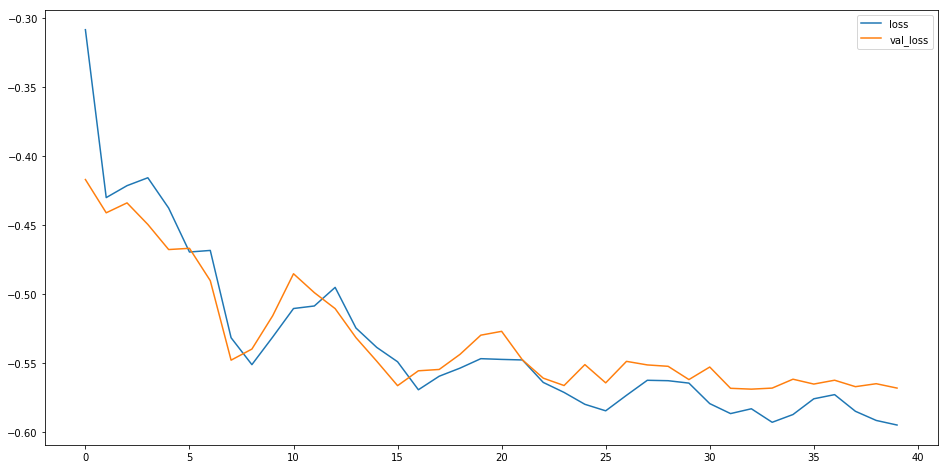

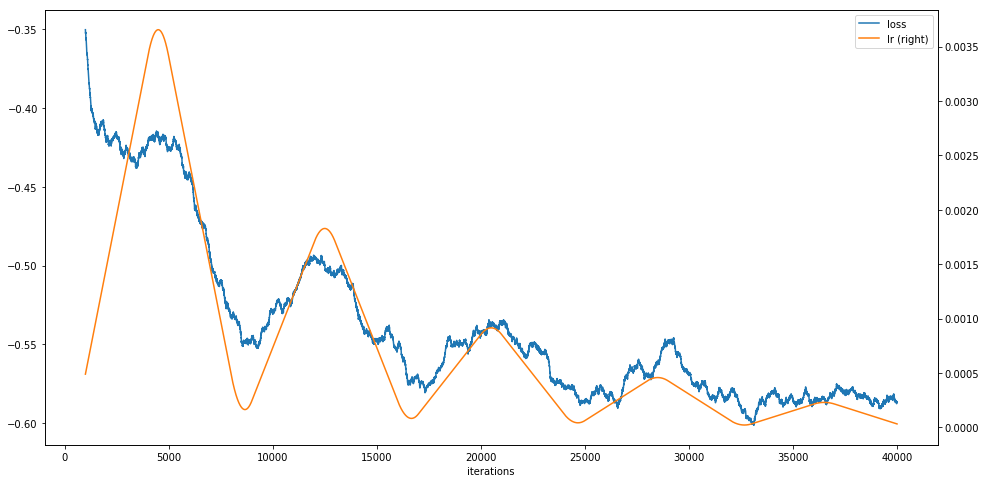

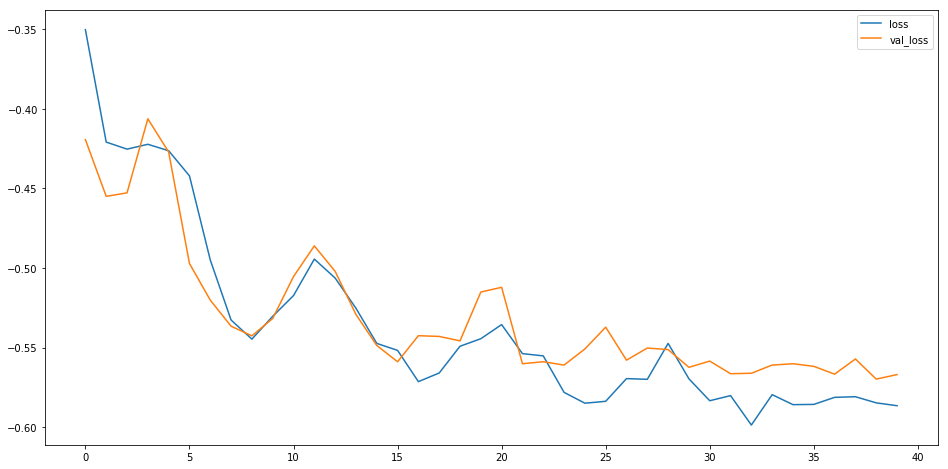

In [19]:
train_oof((votes, answers), votes_test)